# Pricing options and their greeks using the Black-Scholes model

In [1]:
from scipy.stats import norm
import numpy as np
from scipy.optimize import minimize_scalar
import pandas_datareader.data as web
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def d1(S,K,r,sigma,T):
    return ((np.log(S/K) + (r + (sigma**2) / 2) * T)) / (sigma * np.sqrt(T))

def d2(S,K,r,sigma,T):
    return d1(S,K,r,sigma,T) - sigma * np.sqrt(T)

# class structure to introduce the pricing and greek calculation for calls,

In [3]:
class call:
    def callprice(self,S,K,r,sigma,T):
        return norm.cdf(d1(S,K,r,sigma,T)) * S - norm.cdf(d2(S,K,r,sigma,T)) * K * np.exp(-r*T)
    
    def calldelta(self,S,K,r,sigma,T):
        return norm.cdf(d1(S,K,r,sigma,T))

    def callgamma(self,S,K,r,sigma,T):
        return norm.pdf(d1(S,K,r,sigma,T)) / (S * sigma * np.sqrt(T))

    def callvega(self,S,K,r,sigma,T):
        return S * norm.pdf(d1(S,K,r,sigma,T))*np.sqrt(T)

    def calltheta(self,S,K,r,sigma,T):
        return (-S * norm.pdf(d1(S,K,r,sigma,T)) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2(S,K,r,sigma,T))
    
    def __init__(self,S,K,r,sigma,T):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.price = self.callprice(S,K,r,sigma,T)
        self.delta = self.calldelta(S,K,r,sigma,T)
        self.gamma = self.callgamma(S,K,r,sigma,T)
        self.vega = self.callvega(S,K,r,sigma,T)
        self.theta = self.calltheta(S,K,r,sigma,T)

In [4]:
class put:
    def putprice(self, S, K, r, sigma, T):
        return norm.cdf(-d2(S,K,r,sigma,T)) * K * np.exp(-r * T) - norm.cdf(-d1(S,K,r,sigma,T)) * S

    def putdelta(self, S, K, r, sigma, T):
        return norm.cdf(d1(S, K, r, sigma, T)) - 1

    def putgamma(self, S, K, r, sigma, T):
        return norm.pdf(d1(S, K, r, sigma, T)) / (S * sigma * np.sqrt(T))

    def putvega(self, S, K, r, sigma, T):
        return S * norm.pdf(d1(S, K, r, sigma, T)) * np.sqrt(T)

    def puttheta(self, S, K, r, sigma, T):
        return (-S * norm.pdf(d1(S, K, r, sigma, T)) * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2(S, K, r, sigma, T))

    def __init__(self,S,K,r,sigma,T):
        self.S = S
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.price = self.putprice(S,K,r,sigma,T)
        self.delta = self.putdelta(S,K,r,sigma,T)
        self.gamma = self.putgamma(S,K,r,sigma,T)
        self.vega = self.putvega(S,K,r,sigma,T)
        self.theta = self.puttheta(S,K,r,sigma,T)

# An alternate pricing method: Monte-Carlo simulation
Another way to price options is through the Monte-Carlo method, which has uses random sampling in order to estimate the paths of the underlying stock. We use these price at expiry (t=T) to then estimate the options price. This method has its advantages over Black-Scholes as it is a lot more versatile in being able to value options with non-standard features. Here I will go over an example to price an option using this method.

In [5]:
def path(S,T,r,sigma,steps,N):
    
    dt = T/steps
    
    S_T = np.log(S) + np.cumsum(((r - sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=(steps,N))), axis=0)
    
    return np.exp(S_T)

In [6]:
S = 100
T = 1
r = 0.03
K = 110
sigma = 0.25

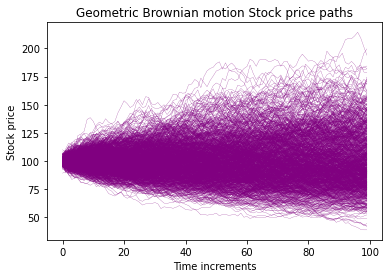

In [17]:
steps = 100
N = 1000

paths = path(S,T,r,sigma,steps,N)
plt.plot(paths,color = 'purple', linewidth = 0.2);
plt.xlabel('Time increments')
plt.ylabel('Stock price')
plt.title('Geometric Brownian motion Stock price paths');

In [8]:
def final_stockprice(S, r, sigma, Z, T):
    return S * np.exp((r - sigma**2/2)*T + sigma*np.sqrt(T)*Z)

def callprice_montecarlo(S_T, r, K, T):
    return np.exp(-r*T) * np.maximum(S_T-K, 0)

samplesize = 100
N = 10000

call_prices_mean = [None]*samplesize

np.random.seed(2)

for i in range(1, samplesize+1):
    
    norm_array = norm.rvs(size = N*i)
    
    stock_prices = final_stockprice(S, r, sigma, norm_array, T)
    
    call_prices = callprice_montecarlo(stock_prices, r, K, T)
    
    call_prices_mean[i-1] = np.mean(call_prices)

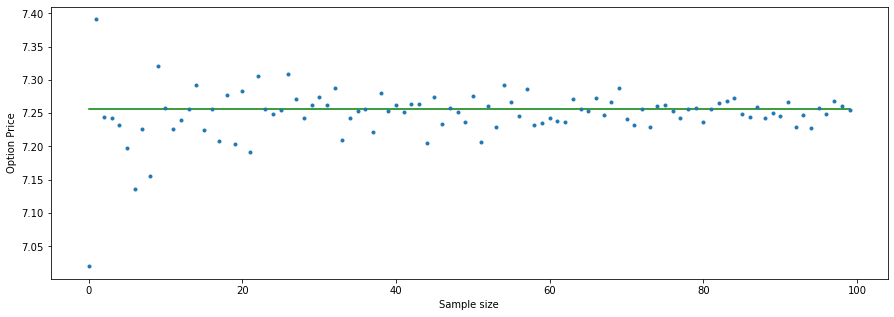

In [9]:
analyticprice=call(S,K,r,sigma,T).price

fig,ax=plt.subplots()
fig.set_size_inches(15,5)

ax.plot([analyticprice]*samplesize,"green")
ax.plot(call_prices_mean, ".")
ax.set_xlabel("Sample size");
ax.set_ylabel("Option Price");

In [10]:
longaapl = call(138,140,0.03,0.43,30/365)
print(f"Price: {1000*longaapl.price}")

Price: 6027.524323007221


In [11]:
print(f"Delta: {1000*longaapl.delta}")
print(f"Vega: {1000*longaapl.vega}")
print(f"Gamma: {1000*longaapl.gamma}")

Delta: 486.0086511632232
Vega: 15773.793477732834
Gamma: 23.435872778390333


# Limitations of the Black-Scholes model

# Distribution of stock returns

This model was built on the assumption that stock prices are log-normally distributed. Log-normal distributions of prices implies normal distributions of returns. However, empirically this is not the case. There occur large price spikes in markets due to unprecedented events, creating a fat-tailed distribution for returns which differs from normal. Let us view the stock returns for Apple and compare it to a normal distribution with an equal mean and variance,

[*********************100%***********************]  1 of 1 completed


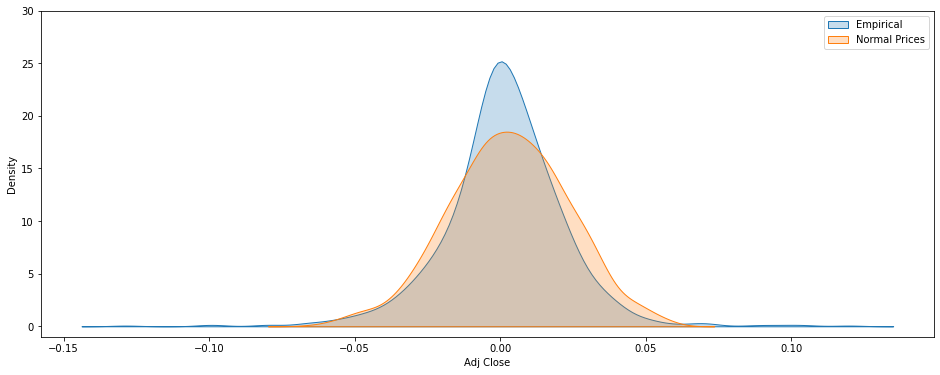

In [12]:
import matplotlib.pyplot as plt
import numpy as np

stock='AAPL'
prices = yf.download(stock,start='2018-01-01',end='2022-10-05')['Adj Close'];
returns =
prices.pct_change()[1:]

std = returns.std()
mean = returns.mean()

normal = np.random.normal(mean,std,size=len(returns))
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
ax = sns.kdeplot(data=returns, label='Empirical', ax=ax,fill=True)
ax = sns.kdeplot(data=normal, label='Normal Prices', ax=ax,fill=True)
plt.ylim([-1,30])

ax.legend();

# You can visibly see the fatter tails occuring, To further confirm this, we may perform a Shapiro-Wilk test for normality,

In [13]:
import scipy.stats as st

def shapirotest(data):
    x, p = st.shapiro(data)
    if p > 0.05:
        return "Normal distribution"
    else:
        return "Non-normal distribution"
        
shapirotest(returns)

'Non-normal distribution'